In [9]:
# imports
import torch
import torchaudio
import torchaudio.transforms as aud_transforms
import torch.nn as nn
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display

torchaudio.set_audio_backend("sox_io")

# Differentiable transforms

## Pitch shift

In [ ]:
def

## Gaussian Noise

In [8]:
genre = 'blues'
number = '00001'

music_path = f"data/WAV/{genre}/{genre}.{number}.wav"

wd, sr = torchaudio.load(music_path)
resampler = aud_transforms.Resample(sr, 16000)
audio = resampler(wd).squeeze()
# wd.shape
sr, audio.shape

(22050, torch.Size([480214]))

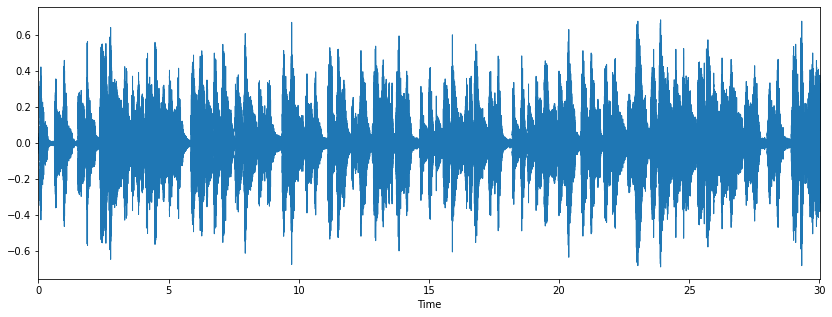

In [13]:
def display_wave(wd):
    plt.figure(figsize=(14, 5))
    librosa.display.waveplot(wd.numpy(), sr=16000)
display_wave(audio)

In [30]:
def g_noise_inj(x, snr):
    print(x.shape)
    x = x.unsqueeze(0)
    print(x.shape)
    
    bs = x.shape[0]
    sample_length = x.shape[1]

    g_noise = np.random.randn(sample_length)
    # snr = torch.rand(bs, device=self.lims.device) * (self.lims[1] - self.lims[0]) + self.lims[0]

    noise_power = np.mean(np.power(g_noise, 2))
    sig_power = torch.mean(torch.pow(x, 2))

    snr_linear = 10**(snr / 10.0)
    print(noise_power)
    print(sig_power)
    print(snr_linear)
    noise_factor = torch.sqrt( (sig_power / noise_power) * (1 / snr_linear) )
    print(noise_factor)
    # noise_factor = noise_factor.unsqueeze(dim=1).expand(bs, sample_length)
    g_noise = torch.from_numpy(g_noise)
    vals = noise_factor * g_noise
    
    return torch.add(x, vals)

tensor([0.9051, 1.0000])
torch.Size([480214])
torch.Size([1, 480214])
0.9997357456015673
tensor(0.0116)
tensor(1.2317)
tensor(0.0969)
torch.Size([1, 480214])


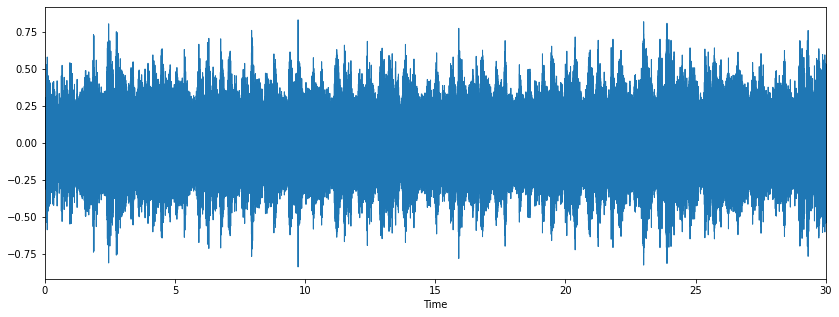

In [42]:
lim = torch.sigmoid(torch.tensor([3., 12.])) * 2 - 1
print(lim)
injected_audio = g_noise_inj(audio, lim[0])
print(injected_audio.shape)
display_wave(injected_audio.squeeze())

In [58]:
class GaussianNoiseAug(nn.Module):
    """
    Differetiable Gaussian noise injection
    """
    def __init__(self):
        super().__init__()
        self.aug=True
        self.log_lims = nn.Parameter(torch.tensor([1., 4.]))

    @property
    def lims(self):
        return torch.sigmoid(self.log_lims) * 2 - 1

    def forward(self, x):
        bs = x.shape[0]
        sample_length = x.shape[1]
        snr_range = torch.tensor([self.lims[0] * 3, self.lims[1] * 3])
        print(snr_range)
        g_noise = np.random.randn(sample_length)
        snr = torch.rand(bs, device=self.lims.device) * (snr_range[1] - snr_range[0]) + snr_range[0]

        noise_power = np.mean(np.power(g_noise, 2))
        sig_power = torch.mean(torch.pow(x, 2))

        snr_linear = 10**(snr / 10.0)
        noise_factor = torch.sqrt( (sig_power / noise_power) * (1 / snr_linear) )

        # noise_factor = noise_factor.unsqueeze(dim=1).expand(bs, sample_length)
        g_noise = torch.from_numpy(g_noise)
        vals = noise_factor * g_noise
        
        return torch.add(x, vals)

In [61]:
crite
aug_model = GaussianNoiseAug()
print(aug_model.lims)
print(audio.shape)
print(list(aug_model.parameters()))
optimizer = torch.optim.Adam(aug_model.parameters(), lr=1)
optimizer.zero_grad()
out = aug_model(audio.unsqueeze(0))
optimizer.step()
print(aug_model.lims)


tensor([0.4621, 0.9640], grad_fn=<SubBackward0>)
torch.Size([480214])
[Parameter containing:
tensor([1., 4.], requires_grad=True)]
tensor([1.3864, 2.8921])
tensor([0.4621, 0.9640], grad_fn=<SubBackward0>)
